In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import datetime
import time
import pickle
import json

from pymongo import MongoClient
from pprint import pprint
from gensim.models import CoherenceModel
from nltk.tag import StanfordNERTagger 
from nltk.corpus import stopwords

from themeter.dev.model_testing import get_coherence_vals
from text_processing import (tag_words,remove_stopwords,
                             remove_sw,process_doc,
                            bigrams,refactor_corpus,get_corpus)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
np.random.seed(1960)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderbailey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [334]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Database Retrieval

Having stored my database on Mongo previously, all I need to do is connect to my database and retrieve the data. When the data is retrieved from Mongo, it comes with an extra id column. Since the id is of no use to me I will drop it and check my dataframe.

In [269]:
# with open('/Users/alexanderbailey/.secret/mongo_creds.json','r') as f:
#     params = json.load(f)

# url = 'mongodb+srv://zmbailey:' + params['password'] + '@cluster0-ykzgc.mongodb.net/test?retryWrites=true&w=majority'

# client = MongoClient(url)

In [271]:
# mongodb = client.movieplots
# mongo_summaries = mongodb.movies
# movies = pd.DataFrame(list(mongo_summaries.find()))
# movies = movies[['summary','title']]
# print(movies.shape)
# movies.head()

(56005, 2)


,summary,title
0,nown as 1 Life On The Limit is a 2013 document...,1 (2013 film)
1,While on the phone with his girlfriend Jill w...,+1 (film)
2,Gully Mercer Mick Rossi leads a group of prol...,2:22 (2008 film)
3,o Christmas is a Ghanaian drama movie about Re...,6 Hours To Christmas
4,r is a 1995 American romantic drama television...,The Affair (1995 film)


Since you will not have access to my MongoDB, I have also included my data files as json. Here is the code to import those instead:

In [ ]:
movies1_df = pd.read_json('themeter/dev/data/eng_1_430.json')
movies2_df = pd.read_json('themeter/dev/data/eng_431_601.json')
movies = movies1_df.append(movies2_df)
print(movies1_df.shape)
print(movies2_df.shape)
movies.head()

## Data Prepration

My dataset is a little large to work with, given the size of each text entry. Certain operations take an impractical amount of time, so I will take a smaller sample, and break that up for processing.

In [489]:
import random
np.random.seed(1960)
sample = np.random.choice(list(movies['summary']),25000)
sample1 = sample[:12501]
sample2 = sample[12501:]

### Named Entity Recognition

Movie summaries contain a considerable number of names, both of people and places, which throw off the topic modeling. In order to avoid this, I can use NER to identify names so I can remove them. However, NER takes a long time to run on my data, so I have commented the line out, and pickled the results so that I can quickly load it later.   

In [ ]:
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz',
                       '/stanford-ner-2018-10-16/stanford-ner.jar')
#names1 = tag_words(sample1, st)
#names2 = tag_words(sample2, st)

In [ ]:
# with open('data/names_list1.pkl', 'wb') as f:
#     pickle.dump(names, f)

In [101]:
with open('data/names_list1.pkl', 'rb') as f1:
    names1 = pickle.load(f1)
with open('data/names_list2.pkl', 'rb') as f2:
    names2 = pickle.load(f2)
    
names = set(names1).union(set(names2))

In [132]:
len(names.union(set(map(lambda x: x.lower(),names))))

113746

Now that I have the list of names I can append it to the stoplist so any names will be removed from the text.

In [554]:
names = names.union(set(map(lambda x: x.lower(),names)))
stop_words = stopwords.words('english')
stop_words += ['film', 'directed', 'film_directed', 'series',
               'story', 'american', 'starring', 'films', 'direct',
               'produced', 'stars', 'released','premiered','features',
              'featuring','interviews','release','version','performances',
              'performance','perform','titled','title','distributed','featured',
              'adaptation','character','role','including','january','febuary',
              'march','april','may','june','july','august','september','november'
              ,'december']
 
stop_words = set(stop_words).union(names)

In [327]:
# with open('themeter/dev/jar/stopwords.pkl', 'wb') as f:
#     pickle.dump(stop_words, f)

Now that we have the stopwords configured, we can preprocess the text.

In [555]:
now = datetime.datetime.now()
m_corpus, m_id2word, bigram = get_corpus(sample,stop_words)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

Time:  0:00:24.518061


In [324]:
with open('jar/id2word.pkl','wb') as f:
    pickle.dump(m_id2word,f)

Now I create my first test LDA model, to see what the topics are like. 

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=m_corpus,
                                       num_topics=10,
                                       id2word=m_id2word,
                                       chunksize=100,
                                       eval_every=1,
                                       per_word_topics=True,
                                       passes=20,
                                       workers=4)

for idx, topic in lda_model.print_topics(num_topics=-1):
    print('Topic : {} Word: {}'.format(idx, topic))

Now I'm creating a series of models to looks at coherence values for different numbers of topics. Coherence values are indicitive of the human interpretability of the topics, so this will help me find topics that will be more meaning output. 

In [453]:
#85 = 8
#125 = 12

# def get_coherence_vals(start,end,step):
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start,end,step):
#         model = gensim.models.LdaMulticore(corpus=m_corpus,
#                                            num_topics=num_topics,
#                                            id2word=m_id2word,
#                                            chunksize=100,
#                                            eval_every=1,
#                                            per_word_topics=True,
#                                            passes=20,
#                                            workers=3,
#                                            random_state=125)
#         model_list.append(model)

#         coherencemodel = CoherenceModel(model=model, 
#                                         texts=bigram,
#                                         dictionary=m_id2word,
#                                        coherence='c_v')
#         print('model with ' + str(num_topics) + ' topics')
#         coherence_values.append(coherencemodel.get_coherence())
    
#     return model_list,coherence_values

## First Model

Doing a broad search to look for trends.

In [582]:
now = datetime.datetime.now()
models3, coherence3 = get_coherence_vals(5,20,1,m_corpus,m_id2word,bigram,226)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

model with 5 topics
model with 6 topics
model with 7 topics
model with 8 topics
model with 9 topics
model with 10 topics
model with 11 topics
model with 12 topics
model with 13 topics
model with 14 topics
model with 15 topics
model with 16 topics
model with 17 topics
model with 18 topics
model with 19 topics
Time:  0:53:25.347835


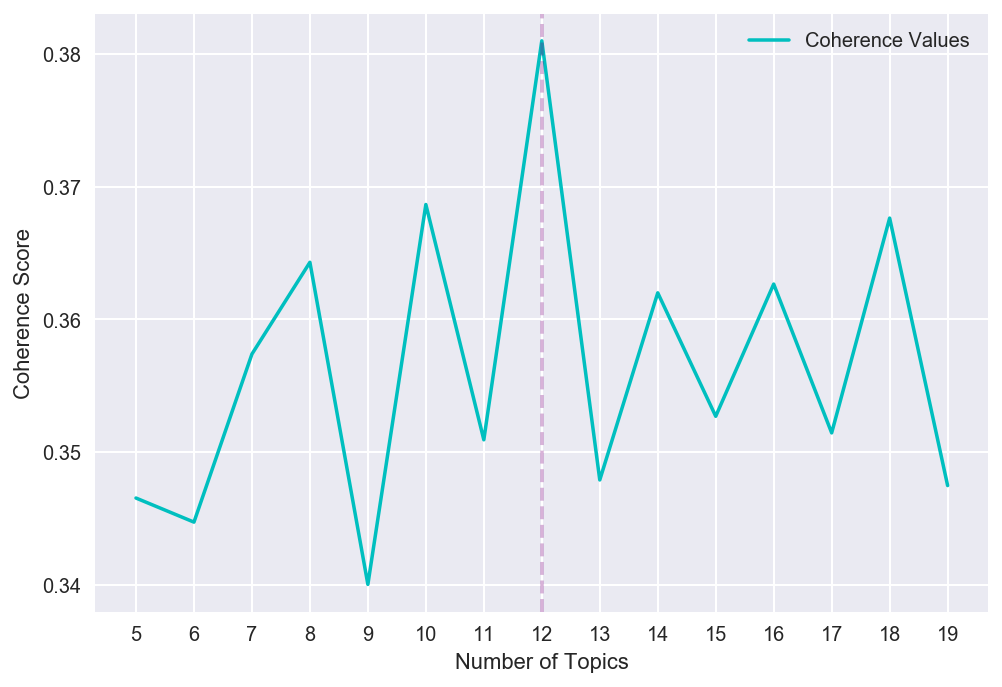

In [589]:

X = range(5,20,1)

fig, ax = plt.subplots()
ax.plot(X, coherence3, color="c", label="Coherence Values")
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_xticks(range(5,20))
ax.axvline(12,linestyle='--',alpha=0.3,color="purple")

plt.legend()

In [574]:
for m, cv in zip(X, coherence3):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3615
Num Topics = 6  has Coherence Value of 0.3568
Num Topics = 7  has Coherence Value of 0.3668
Num Topics = 8  has Coherence Value of 0.3651
Num Topics = 9  has Coherence Value of 0.3631
Num Topics = 10  has Coherence Value of 0.363
Num Topics = 11  has Coherence Value of 0.3582
Num Topics = 12  has Coherence Value of 0.3552
Num Topics = 13  has Coherence Value of 0.352
Num Topics = 14  has Coherence Value of 0.3674
Num Topics = 15  has Coherence Value of 0.3452
Num Topics = 16  has Coherence Value of 0.3548
Num Topics = 17  has Coherence Value of 0.3382
Num Topics = 18  has Coherence Value of 0.357
Num Topics = 19  has Coherence Value of 0.3468
Num Topics = 20  has Coherence Value of 0.3726


From this set of models, it looks like the one with 12 topics has the most interpretability.
I will use the 12 topic model from this set.

In [584]:
for topic in range(12):
    print('[', end="")#'Topic ' + str(topic) + ': ')
    for word in range(10):
        print("'" + models3[7].show_topic(topic)[word][0] + "', ", end="")
    print(']')


['would', 'different', 'final', 'shown', 'focuses', 'include', 'th', 'script', 'explores', 'writer', ]
['maid', 'narrator', 'questioning', 'draws', 'effort', 'earned', 'affection', 'portrayed', 'townsfolk', 'ants', ]
['plane', 'bomb', 'flight', 'pilot', 'scientist', 'infected', 'passengers', 'helicopter', 'fuel', 'survive', ]
['played', 'romantic', 'includes', 'debut', 'received', 'screened', 'inspired', 'period', 'inmates', 'painting', ]
['tries', 'runs', 'begins', 'starts', 'makes', 'getting', 'playing', 'turns', 'throws', 'onto', ]
['leave', 'reveals', 'killed', 'tries', 'named', 'begins', 'discovers', 'attempts', 'apartment', 'runs', ]
['th', 'aliens', 'leads', 'thugs', 'minister', 'defeats', 'humans', 'residents', 'execution', 'plans', ]
['decides', 'meets', 'relationship', 'become', 'married', 'leave', 'would', 'agrees', 'gives', 'apartment', ]
['killed', 'ship', 'attempt', 'plan', 'captured', 'discover', 'led', 'manages', 'sent', 'named', ]
['trial', 'evidence', 'confession', 'h

After looking over the 12 topics to confirm coherence, I will now assign names to each topic.

### Topics 1


Creation: ['would', 'different', 'final', 'shown', 'focuses', 'include', 'th', 'script', 'explores', 'writer', ]

Drama: ['maid', 'narrator', 'questioning', 'draws', 'effort', 'earned', 'affection', 'portrayed', 'townsfolk', 'ants', ]

Action: ['plane', 'bomb', 'flight', 'pilot', 'scientist', 'infected', 'passengers', 'helicopter', 'fuel', 'survive', ]

Art: ['played', 'romantic', 'includes', 'debut', 'received', 'screened', 'inspired', 'period', 'inmates', 'painting', ]

Beginning: ['tries', 'runs', 'begins', 'starts', 'makes', 'getting', 'playing', 'turns', 'throws', 'onto', ]

Tension: ['leave', 'reveals', 'killed', 'tries', 'named', 'begins', 'discovers', 'attempts', 'apartment', 'runs', ]

Espionage: ['th', 'aliens', 'leads', 'thugs', 'minister', 'defeats', 'humans', 'residents', 'execution', 'plans', ]

Romance: ['decides', 'meets', 'relationship', 'become', 'married', 'leave', 'would', 'agrees', 'gives', 'apartment', ]

Mystery: ['killed', 'ship', 'attempt', 'plan', 'captured', 'discover', 'led', 'manages', 'sent', 'named', ]

Crime: ['trial', 'evidence', 'confession', 'heroin', 'spell', 'lawyer', 'guilty', 'accused', 'sentence', 'arrest', ]

Thriller: ['murdered', 'victims', 'died', 'whose', 'tape', 'thriller', 'victim', 'discovers', 'couple', 'evidence', ]

Adventure: ['concerns', 'roles', 'creatures', 'stake', 'airplane', 'theory', 'cases', 'existence', 'transforms', 'loyalty', ]


## Second Model

Because of the variation in the way topics are generated, I am looking at a second model, to test the possibilty of getting different topics from another seed.

In [556]:
now = datetime.datetime.now()
models4, coherence4 = get_coherence_vals(5,21,1,m_corpus,m_id2word,bigram,900)
later = datetime.datetime.now()
elapsed = later-now
print("Time: ", elapsed)

model with 5 topics
model with 6 topics
model with 7 topics
model with 8 topics
model with 9 topics
model with 10 topics
model with 11 topics
model with 12 topics
model with 13 topics
model with 14 topics
model with 15 topics
model with 16 topics
model with 17 topics
model with 18 topics
model with 19 topics
model with 20 topics
Time:  0:29:43.657713


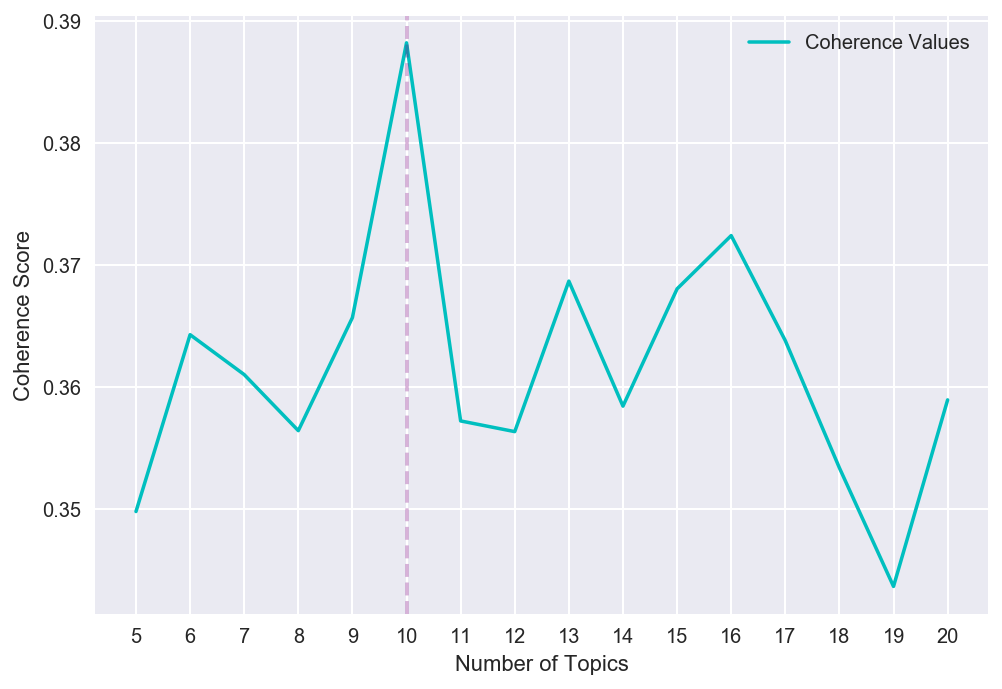

In [588]:

X = range(5,21,1)

fig, ax = plt.subplots()
ax.plot(X, coherence4, color="c", label="Coherence Values")
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Coherence Score')
ax.set_xticks(range(5,21))
ax.axvline(10,linestyle='--',alpha=0.3,color="purple")

plt.legend()

It now appears that 10 is a good number of topics, so I will investigate the model with 10.

In [559]:
for topic in range(10):
    print('[', end="")#'Topic ' + str(topic) + ': ')
    for word in range(10):
        print("'" + models4[5].show_topic(topic)[word][0] + "', ", end="")
    print(']')


['ship', 'plane', 'flight', 'pilot', 'bomb', 'scientist', 'passengers', 'ships', 'aliens', 'destroyed', ]
['tape', 'deals', 'presented', 'fog', 'prominent', 'firm', 'residents', 'involved', 'term', 'fishing', ]
['concerns', 'played', 'precode', 'narrator', 'nd', 'edited', 'teams', 'player', 'airplane', 'marijuana', ]
['shown', 'romantic', 'received', 'includes', 'focuses', 'played', 'bands', 'screened', 'script', 'musician', ]
['tries', 'runs', 'begins', 'leave', 'starts', 'makes', 'turns', 'attempts', 'gives', 'saying', ]
['wins', 'turns', 'decides', 'attempt', 'final', 'become', 'would', 'whose', 'loses', 'makes', ]
['meets', 'decides', 'relationship', 'apartment', 'leave', 'agrees', 'would', 'become', 'married', 'begins', ]
['killed', 'reveals', 'leave', 'named', 'discovers', 'attempts', 'plan', 'taken', 'manages', 'others', ]
['named', 'begins', 'died', 'murdered', 'victims', 'curse', 'discovers', 'become', 'victim', 'whose', ]
['th', 'debut', 'thriller', 'writer', 'played', 'final

These topics look good, so I will assign these topics names.

### Topics 2

Action: ['ship', 'plane', 'flight', 'pilot', 'bomb', 'scientist', 'passengers', 'ships', 'aliens', 'destroyed', ]

Small Town: ['tape', 'deals', 'presented', 'fog', 'prominent', 'firm', 'residents', 'involved', 'term', 'fishing', ]

Sports: ['concerns', 'played', 'precode', 'narrator', 'nd', 'edited', 'teams', 'player', 'airplane', 'marijuana', ]

Performance: ['shown', 'romantic', 'received', 'includes', 'focuses', 'played', 'bands', 'screened', 'script', 'musician', ]

On the Run: ['tries', 'runs', 'begins', 'leave', 'starts', 'makes', 'turns', 'attempts', 'gives', 'saying', ]

Games: ['wins', 'turns', 'decides', 'attempt', 'final', 'become', 'would', 'whose', 'loses', 'makes', ]

Relationship Drama: ['meets', 'decides', 'relationship', 'apartment', 'leave', 'agrees', 'would', 'become', 'married', 'begins', ]

Suspense: ['killed', 'reveals', 'leave', 'named', 'discovers', 'attempts', 'plan', 'taken', 'manages', 'others', ]

Mystery: ['named', 'begins', 'died', 'murdered', 'victims', 'curse', 'discovers', 'become', 'victim', 'whose', ]

Thriller: ['th', 'debut', 'thriller', 'writer', 'played', 'final', 'leading', 'upcoming', 'described', 'different', ]

In [585]:
topic_names1 = ['Creation','Drama','Action','Art','Beginning','On the Run',
                'Espionage','Romance','Mystery','Crime','Thriller','Adventure']
topic_names2 = ['Action','Small Town','Sports','Performance','On the Run','Games',
                'Relationship Drama','Suspense','Mystery','Thriller']


In [586]:
with open('themeter/dev/jar/model1.pkl', 'wb') as f:
    pickle.dump(models3[7],f)
    
with open('themeter/dev/jar/model2.pkl', 'wb') as e:
    pickle.dump(models4[5],e)

Now to test the model output with a summary from imdb:

In [587]:
unseen = 'Dr. Richard Kimble, unjustly accused of murdering his wife, must find the real killer' 
unseen += 'while being the target of a nationwide manhunt led by a seasoned U.S. Marshal.'

corp = process_doc(unseen,m_id2word,stop_words)

topic = models3[7].get_document_topics(corp, minimum_probability=0.0)
idx, scores = zip(*topic)
print(topic_names[scores.index(sorted(scores)[-2])])
print(topic_names[scores.index(max(scores))])

On the Run
Courtroom
